<a href="https://colab.research.google.com/github/yosshi3/azuma_lecture_pytorch/blob/master/lecture5/simple_rnn_ishida.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シンプルなRNNの実装
PyTorchを使って、シンプルな再帰型ニューラルネットワーク（RNN）を実装します。  
RNNにノイズ付きサインカーブを学習させて、1つ先の未来を予測することによる曲線の描画を行います。


## 訓練用データの作成
まずは、サインカーブに乱数でノイズを加えてRNNに用いる訓練用のデータを作成します。


## 練習問題０
以下の３パターンのショートカットを覚える。
1. セルの一括実行
1. セル直前まで一括実行
1. セル以降の一括実行


## 練習問題１
モデルをcosカーブに変える。  
データ数を100に変える。  
sin_y の中身の確認する。 

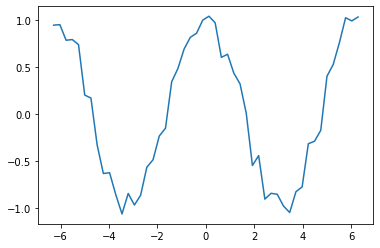

[ 0.95  0.95  0.79  0.79  0.74  0.20  0.17 -0.33 -0.63 -0.63
 -0.86 -1.06 -0.85 -0.97 -0.87 -0.57 -0.49 -0.24 -0.15  0.34
  0.48  0.69  0.82  0.86  1.00  1.04  0.97  0.60  0.64  0.44
  0.32  0.01 -0.55 -0.44 -0.91 -0.85 -0.86 -0.98 -1.05 -0.83
 -0.78 -0.32 -0.29 -0.17  0.40  0.53  0.76  1.02  0.99  1.03]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sin_x = np.linspace(-2*np.pi, 2*np.pi, num=50)  # -2πから2πまで
sin_y = np.cos(sin_x)  + 0.1*np.random.randn(len(sin_x))  # sin関数に乱数でノイズを加える
plt.plot(sin_x, sin_y)
plt.show()

# sin_y の中身の確認
np.set_printoptions(precision=2, floatmode='fixed', linewidth=65)
print(sin_y)


このようなノイズ付きサインカーブの一部を切り取って入力の時系列とし、次の値を予測するようにRNNを訓練します。    
sin波自体は単純な時系列データですが、このようなsin波をニューラルネットワークで学習することができれば、例えば音声認識などに応用することも可能です。  
今回の扱う対象はシンプルですが、現実社会で広く応用が可能することができます。

## データの前処理
入力、正解データをRNNに適した形に整えます。  
時系列から次の値を予測できるように、時系列を入力として正解はその1つ後の値とします。 

## 練習問題２
input_data、correct_dataの型を考える。  
不自然な部分は何か？

In [ ]:
import torch
from torch.utils.data import DataLoader

n_time = 10  # 時系列の数
n_sample = len(sin_x) - n_time  # サンプル数

input_data = np.zeros((n_sample, n_time, 1))  # 入力 n_sample × n_time × 1　ポイントは最後の１次元
correct_data = np.zeros((n_sample, 1))  # 正解 n_sample × 1

print('sin_y.shape ->', sin_y.shape)
print('sin_y[0 : 0 + n_time].shape ->', sin_y[0 : 0 + n_time].shape)
print('sin_y[i : i + n_time].reshape(-1, 1).shape ->', sin_y[0 : 0 + n_time].reshape(-1, 1).shape)
print('sin_y[i : i + n_time].reshape(-1, 1) ->\n', sin_y[0 : 0 + n_time].reshape(-1, 1))

for i in range(n_sample):
    input_data[i] = sin_y[i : i + n_time].reshape(-1, 1)
    correct_data[i] = sin_y[i + n_time : i + n_time + 1]  # 正解は入力よりも一つ後

# 入力と正解の中身を確認
# for i in range(n_sample):
#     print("i=" , i, *input_data[i], " correct: ", correct_data[i])


input_data = torch.tensor(input_data, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(correct_data, dtype=torch.float)

print('input_data ->',input_data.shape)
print('correct_data ->',correct_data.shape)

dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成

train_loader = DataLoader(dataset, batch_size=8, shuffle=True)  # DataLoaderの設定

sin_y.shape -> (50,)
sin_y[0 : 0 + n_time].shape -> (10,)
sin_y[i : i + n_time].reshape(-1, 1).shape -> (10, 1)
sin_y[i : i + n_time].reshape(-1, 1) ->
 [[ 0.95]
 [ 0.95]
 [ 0.79]
 [ 0.79]
 [ 0.74]
 [ 0.20]
 [ 0.17]
 [-0.33]
 [-0.63]
 [-0.63]]
input_data -> torch.Size([40, 10, 1])
correct_data -> torch.Size([40, 1])


## モデルの構築
`nn.Module`モジュールを継承したクラスとして、モデルを構築します。  
RNNは`nn.RNN`を使って実装することができます。


## 練習問題３）
`class Net(nn.Module):`ってどういう意味？  
`def __init__(self):`は、いつ呼ばれるの？  
`def forward(self, x, hidden=None):`は、いつ呼ばれるの？  
`self.rnn()`、`self.fc()`の入力内容は何？ポイントは？


#### 参考
https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

$$
h_t = \tanh(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})
$$

W_ih_l0 -> 64×1  
W_hh_l0 -> 64×64  
h_t -> 1×64

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(  # RNN層
            input_size=1,  # 入力サイズ
            hidden_size=64,  # ニューロン数
            num_layers = 1,
            batch_first=True,  # 入力を (バッチサイズ, 時系列の数, 入力の数) にする。
            #                    デフォルトは（時系列の数, バッチサイズ,  入力の数）らしい。
        )
        self.fc = nn.Linear(64, 1)  # 全結合層

    def forward(self, x, hidden=None):
        y_rnn, h = self.rnn(x, hidden)  # hは次の時刻に渡される値、 Noneでその初期値が0に 
        # input of shape (seq_len, batch, input_size)
        # h_0 of shape (num_layers * num_directions, batch, hidden_size)
        # output of shape (seq_len, batch, num_directions * hidden_size) , batch_first=True (batch, seq_len, num_directions * hidden_size)
        # h_n of shape (num_layers * num_directions, batch, hidden_size)

        # print('y_rnn-> ', y_rnn.shape) # torch.Size([8, 10, 64]) 
        # print('h-> ', h.shape)         # torch.Size([1, 8, 64])
        y = self.fc(y_rnn[:, -1, :])  # yは最後の時刻の出力
        return y

net = Net()
print(net)
print("----")
for param_name, param in net.named_parameters():
    print("\nparam_name-> ", param_name, "\nparam-> ", param)

Net(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
----

param_name->  rnn.weight_ih_l0 
param->  Parameter containing:
tensor([[-1.7021e-02],
        [-5.7624e-02],
        [-6.5935e-02],
        [ 5.0940e-02],
        [-9.8894e-02],
        [-2.9182e-02],
        [ 3.4066e-04],
        [-5.9324e-03],
        [ 9.7910e-02],
        [ 2.8015e-02],
        [-6.5686e-02],
        [ 5.0230e-03],
        [ 4.9480e-02],
        [ 4.9620e-02],
        [-1.2481e-01],
        [ 1.2396e-01],
        [ 2.9520e-02],
        [-1.1914e-02],
        [-3.4762e-02],
        [-4.2768e-02],
        [ 4.4908e-02],
        [-5.1085e-02],
        [-3.1636e-02],
        [-2.1026e-02],
        [ 6.2205e-02],
        [-1.8463e-02],
        [ 5.3134e-02],
        [ 6.2980e-02],
        [ 1.0872e-01],
        [-8.6437e-02],
        [-4.5351e-02],
        [ 9.7561e-02],
        [-1.8286e-03],
        [ 2.9748e-03],
        [-1.0511e-01],
        [ 1.1905e-01],


## 学習
モデルを訓練します。  
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行います。  
訓練したモデルを使い、直近の時系列を使った予測結果を次々と時系列に加えていくことにより、曲線が生成されます。  
学習が進むとともに次第にサインカーブが生成されるようになりますが、曲線は一定のエポック間隔でグラフとして描画されます。  

## 練習問題４

１）オプティマイザに渡しているパラメータの中身を確認する。  
２）オプティマイザを別のアルゴリズムに変えてみる。  
３）訓練中のnet()を利用して、評価時にsin波も追加して予想してみる。

#### 参考）誤差関数
https://end0tknr.hateblo.jp/entry/20191012/1570854032


5
5
5
5
Epoch: 3 Loss_Train: 0.4111198544502258


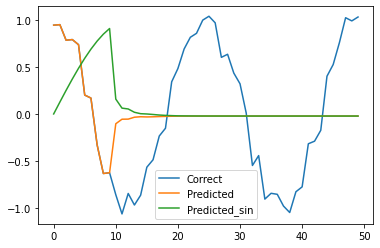

5
5
5
5
Epoch: 7 Loss_Train: 0.292371928691864


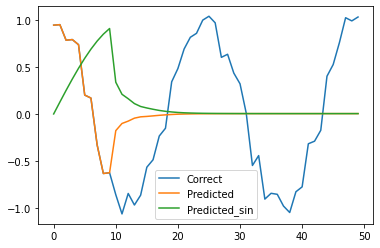

5
5
5
5
Epoch: 11 Loss_Train: 0.19842159152030944


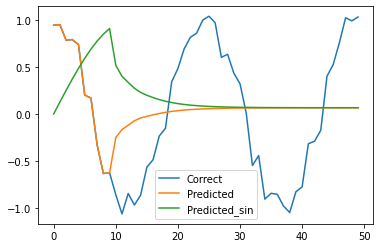

5
5
5
5
Epoch: 15 Loss_Train: 0.1422411948442459


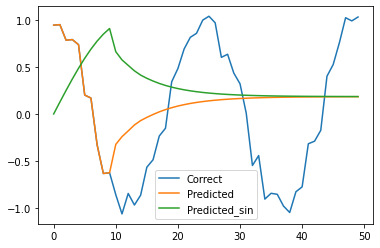

5
5
5
5
Epoch: 19 Loss_Train: 0.10664119124412537


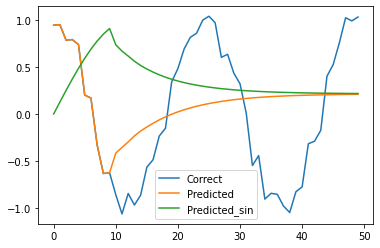

5
5
5
5
Epoch: 23 Loss_Train: 0.0841798536479473


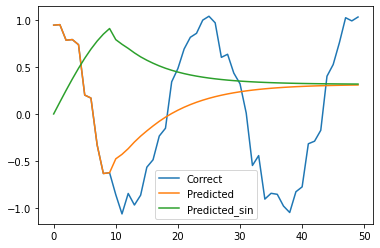

5
5
5
5
Epoch: 27 Loss_Train: 0.06764431148767472


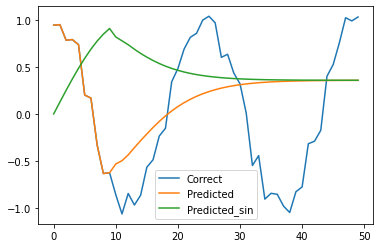

5
5
5
5
Epoch: 31 Loss_Train: 0.05271695554256439


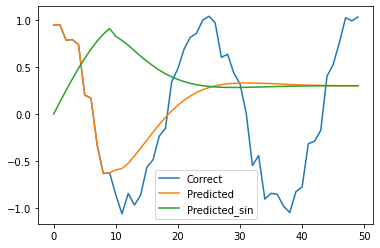

5
5
5
5
Epoch: 35 Loss_Train: 0.04031582772731781


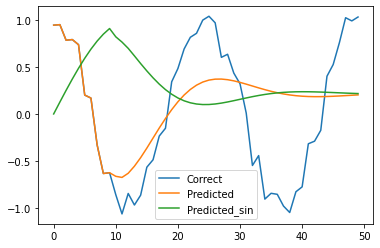

5
5
5
5
Epoch: 39 Loss_Train: 0.02956633623689413


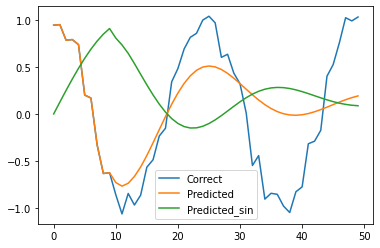

5
5
5
5
Epoch: 43 Loss_Train: 0.023328529484570027


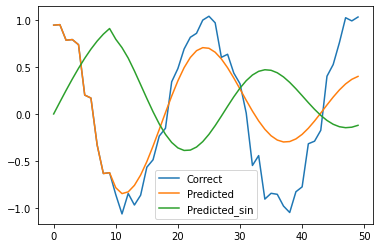

5
5
5
5
Epoch: 47 Loss_Train: 0.020455135218799114


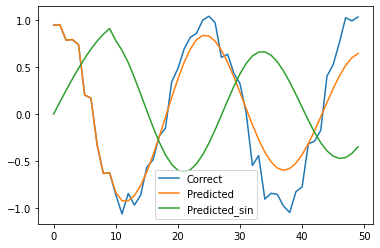

5
5


In [ ]:
from torch import optim

# 交差エントロピー誤差関数　←誤り
# 平均二乗誤差
loss_fnc = nn.MSELoss()

# 最適化アルゴリズム
optimizer = optim.SGD(net.parameters(), lr=0.01)  # 学習率は0.01
# optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []

# 学習
for i in range(50):  # 50エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        
        # 入力と正解の中身を確認
        # x_num = x.numpy()
        # print(x.shape)
        # for k in range(len(x_num)):
        #     print("k=" , k, *x_num[k], " correct: ", t.numpy()[k])

        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad() #前回のbackward結果をクリアする
        loss.backward()  #微分を計算する
        optimizer.step() #勾配を更新する

    print(j+1) # ミニバッチの実行回数
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if (i+1) % 4 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train)

        predicted = list(input_data[0].reshape(-1)) # 最初の入力。つまり最初の10個を取り出す

        # sin波の追加
        sin_y2 = np.sin(np.linspace(-2*np.pi, 2*np.pi, num=100)) #sin波を生成
        sin_y2 = sin_y2[:n_time] #はじめの10個
        predicted2 = list(sin_y2)

        for i in range(n_sample):
            x = torch.tensor(predicted[-n_time:])  # 直近の時系列を取り出す。つまり最後の10個を取り出す
            x = x.reshape(1, n_time, 1)  # (バッチサイズ, 時系列の数, 入力の数)
            y = net(x)
            predicted.append(y[0].item())  # 予測結果をpredictedに追加する

            # print("predicted->" , np.array(predicted))
            # print("predicted[-n_time:]->" , np.array(predicted[-n_time:]))
            # sin波の追加
            x2 = torch.tensor(predicted2[-n_time:]).float()
            x2 = x2.reshape(1, n_time, 1)  # (バッチサイズ, 時系列の数, 入力の数)
            y2 = net(x2)
            predicted2.append(y2[0].item())  # 予測結果をpredicted2に追加する

        plt.plot(range(len(sin_y)), sin_y, label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.plot(range(len(predicted2)), predicted2, label="Predicted_sin")
        plt.legend()
        plt.show()
        

## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

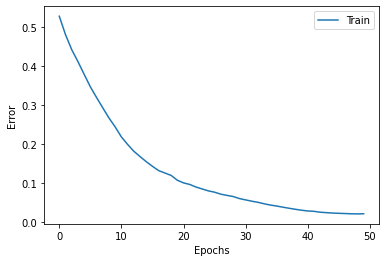

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

滑らかに誤差が減少していることが確認できます。